Credit Card Fraud Detection Using GANs

![flow_diagram](flow.jpeg "Flow Diagram")

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler


df = pd.read_csv('./creditcard.csv')


df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
X = df.drop(['Class', 'Time'], axis=1)
y = df['Class']


latent_dim = 100

# Build the Generator
def build_generator(latent_dim):
    model = Sequential()

    model.add(Dense(128, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(X.shape[1], activation='tanh'))  # Output layer size must match the number of input features

    return model

# Build the Discriminator
def build_discriminator(data_shape):
    model = Sequential()

    model.add(Dense(512, input_dim=data_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    return model

# GAN Utility Functions
def get_real_samples(batch_size):
    idx = np.random.randint(0, X.shape[0], batch_size)
    real_samples = X.iloc[idx].values
    real_labels = np.ones((batch_size, 1))  # Label for real samples is 1
    return real_samples, real_labels

def generate_latent_points(batch_size):
    return np.random.normal(0, 1, (batch_size, latent_dim))

def generate_fake_samples(generator, batch_size):
    latent_points = generate_latent_points(batch_size)
    fake_samples = generator.predict(latent_points)
    fake_labels = np.zeros((batch_size, 1))  # Label for fake samples is 0
    return fake_samples, fake_labels

# Assemble the GAN
generator = build_generator(latent_dim)
discriminator = build_discriminator(X.shape[1])
discriminator.trainable = False  
gan_input = Input(shape=(latent_dim,))
fake_samples = generator(gan_input)
gan_output = discriminator(fake_samples)
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Training the GAN
def train_gan(epochs, batch_size):
    for epoch in range(epochs):
        real_samples, real_labels = get_real_samples(batch_size // 2)

        fake_samples, fake_labels = generate_fake_samples(generator, batch_size // 2)
        
        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)

        d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)
        
        latent_points = generate_latent_points(batch_size)
        
        fake_labels = np.ones((batch_size, 1))
        
        g_loss = gan.train_on_batch(latent_points, fake_labels)

        
        print(f"Epoch {epoch+1}/{epochs} | D Loss Real: {d_loss_real[0]}, D Loss Fake: {d_loss_fake[0]}, G Loss: {g_loss}")

# Train GAN
train_gan(epochs=5000, batch_size=32)  # Adjust the number of epochs and batch size according to your requirements

1/1 [==============================] - 0s 322ms/step
Epoch 1/5000 | D Loss Real: 0.8694816827774048, D Loss Fake: 0.6735303401947021, G Loss: 0.7681094408035278
1/1 [==============================] - 0s 18ms/step
Epoch 2/5000 | D Loss Real: 0.8279491066932678, D Loss Fake: 0.679472804069519, G Loss: 0.727636456489563
1/1 [==============================] - 0s 18ms/step
Epoch 3/5000 | D Loss Real: 0.6736787557601929, D Loss Fake: 0.6826270222663879, G Loss: 0.693199872970581
1/1 [==============================] - 0s 18ms/step
Epoch 4/5000 | D Loss Real: 0.6942125558853149, D Loss Fake: 0.6960243582725525, G Loss: 0.6672302484512329
1/1 [==============================] - 0s 20ms/step
Epoch 5/5000 | D Loss Real: 0.6511029601097107, D Loss Fake: 0.7424971461296082, G Loss: 0.6519894599914551
1/1 [==============================] - 0s 18ms/step
Epoch 6/5000 | D Loss Real: 0.6605663299560547, D Loss Fake: 0.7585995197296143, G Loss: 0.6156291961669922
1/1 [==============================] - 0s 

         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0  0.098698  0.363787  0.090794  ... -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425 -0.166974  ... -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  0.207643  ...  0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024 -0.054952  ... -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  0.753074  ... -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28    Amount  Class  
0  0.12

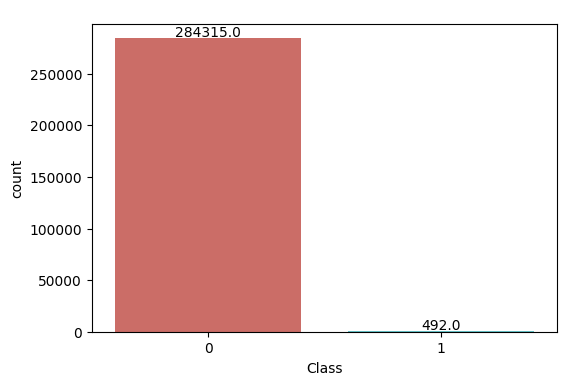

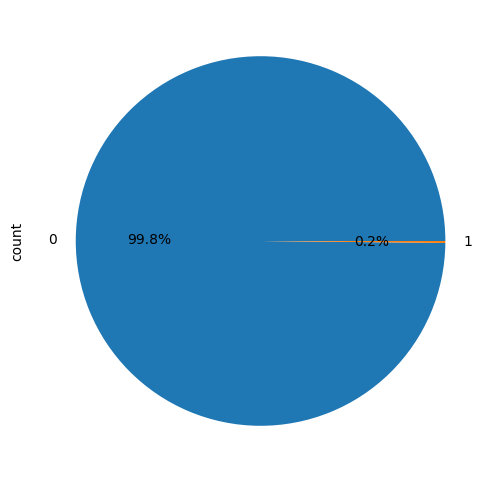

In [ ]:
print(df.head())

print(df.dtypes)

print(df.describe())

print('Number of records (rows) in the dataset are', df.shape[0])
print('Number of attributes (columns) in the dataset are', df.shape[1])
print('Checking Null Values in the dataset: \n', df.isnull().sum())

pd.isna(df).sum()[pd.isna(df).sum() > 0]


print('Checking Null Values in the dataset: \n', df.isnull().sum())

print('Number of duplicate records in the dataset are', df.duplicated().sum())

# labels in categorical features
print('Unique values in the categorical features are: \n', df.select_dtypes(include=['object']).nunique())

object_columns = [(col, df[col].unique()) for col in df.columns if df[col].dtype == 'object']
for col, unique_values in object_columns:
    print(f'\n{col}\n{unique_values}')

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import seaborn as sns
import matplotlib.pyplot as plt

# Check class imbalance
print('Checking class imbalance in the dataset:\n', df['Class'].value_counts())

# Draw bar graph
plt.figure(figsize=(6, 4))  # Set the figure size
ax = sns.countplot(x='Class', data=df, palette='hls')

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

# draw pie chart too with percentages
plt.figure(figsize=(6, 6))
df['Class'].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

In [ ]:
# Number of synthetic samples to create
num_synthetic_samples = 5000

# Generate synthetic transaction data
latent_points = generate_latent_points(num_synthetic_samples)
synthetic_data = generator.predict(latent_points)

synthetic_data_df = pd.DataFrame(synthetic_data, columns=X.columns)

synthetic_data_df['Class'] = 1

157/157 [==============================] - 0s 1ms/step


In [ ]:
# Concatenate the synthetic data with the original data
augmented_data = pd.concat([df, synthetic_data_df])

# Shuffle the augmented dataset
augmented_data = augmented_data.sample(frac=1).reset_index(drop=True)

In [ ]:
if np.isnan(synthetic_data).any():
    synthetic_data = np.nan_to_num(synthetic_data)

synthetic_data_df = pd.DataFrame(synthetic_data, columns=X.columns)
synthetic_data_df['Class'] = 1 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, average_precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

# Assuming generator is a pre-trained generator model from GAN
def generate_synthetic_data(generator, num_samples):
    latent_points = generate_latent_points(num_samples)
    synthetic_data = generator.predict(latent_points)
    return synthetic_data

df = pd.read_csv('creditcard.csv')

# Preprocess the data
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df = df.drop(['Time'], axis=1)

# Split the real data into features and target
X_real = df.drop('Class', axis=1)
y_real = df['Class']

# Generate synthetic data (equal to the number of real instances of the minority class)
num_fraud = y_real.sum()
synthetic_fraud = generate_synthetic_data(generator, num_fraud)

synthetic_df = pd.DataFrame(synthetic_fraud, columns=X_real.columns)
synthetic_df['Class'] = 1

augmented_df = pd.concat([df, synthetic_df])

imputer = SimpleImputer(strategy='mean')
X_augmented = imputer.fit_transform(augmented_df.drop('Class', axis=1))
y_augmented = augmented_df['Class'].values

# Split the augmented data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42)

# Logistic Regression model
lr_model = LogisticRegression(max_iter=10000)
lr_model.fit(X_train, y_train)

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

# XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Make predictions with Logistic Regression
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]

# Make predictions with Random Forest
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Make predictions with XGBoost
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate models
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Calculate Average Precision Score
auprc_lr = average_precision_score(y_test, y_pred_proba_lr)
auprc_rf = average_precision_score(y_test, y_pred_proba_rf)
auprc_xgb = average_precision_score(y_test, y_pred_proba_xgb)

print(f"AUPRC (Logistic Regression): {auprc_lr}")
print(f"AUPRC (Random Forest): {auprc_rf}")
print(f"AUPRC (XGBoost): {auprc_xgb}")

16/16 [==============================] - 0s 2ms/step
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.87      0.27      0.41       199

    accuracy                           1.00     57060
   macro avg       0.93      0.63      0.70     57060
weighted avg       1.00      1.00      1.00     57060

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.98      0.60      0.74       199

    accuracy                           1.00     57060
   macro avg       0.99      0.80      0.87     57060
weighted avg       1.00      1.00      1.00     57060

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.99      0.82      0.90       199

    accuracy      

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, average_precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import tensorflow as tf

# Setup for GPU usage
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Define the generator architecture
def build_generator(latent_dim, output_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=latent_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(output_dim, activation='tanh'))
    return model

# Function to generate latent points
def generate_latent_points(latent_dim, num_samples):
    return np.random.normal(0, 1, (num_samples, latent_dim))

# Function to generate synthetic data
def generate_synthetic_data(generator, latent_dim, num_samples):
    latent_points = generate_latent_points(latent_dim, num_samples)
    synthetic_data = generator.predict(latent_points)
    return synthetic_data

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


df = pd.read_csv('creditcard.csv')

# Preprocess the data
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df = df.drop('Time', axis=1)

# Define latent space dimension and instantiate generator
latent_dim = 100
output_dim = df.shape[1] - 1
generator = build_generator(latent_dim, output_dim)


# Determine how many synthetic samples to create
required_synthetic_rows = max(200000 - df.shape[0], 0)
if required_synthetic_rows > 0:
    # Generate synthetic data
    synthetic_data = generate_synthetic_data(generator, latent_dim, required_synthetic_rows)
    synthetic_df = pd.DataFrame(synthetic_data, columns=df.columns[:-1])  
    synthetic_df['Class'] = 1
    df = pd.concat([df, synthetic_df])

imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(df.drop('Class', axis=1))
y = df['Class'].values

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate the models
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]
    print(classification_report(y_test, predictions))
    auprc_score = average_precision_score(y_test, proba)
    print(f'AUPRC: {auprc_score}\n')
    return auprc_score

print("Logistic Regression Results:")
evaluate_model(lr_model, X_test, y_test)

print("Random Forest Results:")
evaluate_model(rf_model, X_test, y_test)

print("XGBoost Results:")
evaluate_model(xgb_model, X_test, y_test)


Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.58      0.70        98

    accuracy                           1.00     56962
   macro avg       0.93      0.79      0.85     56962
weighted avg       1.00      1.00      1.00     56962

AUPRC: 0.7608664845090545

Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.77      0.86        98

    accuracy                           1.00     56962
   macro avg       0.99      0.88      0.93     56962
weighted avg       1.00      1.00      1.00     56962

AUPRC: 0.8614411218016134

XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.80      0.88        98

    accuracy                           1.00     56962
   ma

0.8812732743523017